# Logistic regression: intuitive explanation

When even crossed hockey sticks won't help fit perfectly separated data. Huh!

## Who ordered this?!

As of this writing, Google search for "logistic regression tutorial" shows about 11.2M results. Why add another thing to this pile?

Because after reading a good number of articles, books, guides and various other types of documentation, I realized that they fall into at least one or more of these categories:

1. Correct, but any intuitive explanations are buried deep underneath the sea of matrix manipulation and Greek alphabet.
2. Misleading.
3. Just plain wrong.

Compounding this, there are a lot of scientists in general dabbling with data without a STEM background. Even after going through all the math, a person typically ends up providing abstract mathematical explanations ("this works because the math works out that way"). In my experience this only adds to the understanding _after_ the topic is understood conceptually.

Given this, we start by clearing up common misconceptions. Logistic regression is **not**:

- linear regression but with a sigmoid curve replacing a line
- classification algorithm
- sigmoid curve "fit" of a decision boundary separating two classes of points in the x-y plane

Some of these can be summarized in the following hand-drawn images that summarize internet search for "logistic regression":

![Image of not logistic regressions](../images/not_a_logit.png)

Instead of trying to decipher these, we will start from the beginning.

By the way, across this post, we will be using Python for calculations and simulation, but R can be used equally well.

## What _is_ a logistic regression?

Logistic regression is a regression model that returns a probability of a binary outcome (0 or 1), assuming that log of the odds is a linear combination of one or more inputs. Odds is a ratio between probability of outcome happening and the probability of the outcome not happening: $p/(1-p)$. When we have one input/predictor, this starting assumption is mathematically expressed as:

$$\log\frac{p}{1-p} = \beta_1 x + \beta_0$$

Therefore, the goal behind logistic regression is to model cases when the input(s) are affecting the outcome by shifting the probability of 0 to 1 in a multiplicative manner. For example, maybe for one value of input $x$, the odds is 2 (so y being 1 is twice as likely than 0), and for another value if input the odds could be 4 (so y being 1 becomes four times as likely than 0).

The probability that the outcome is 1, $p$,  can be derived from the previous equation:

$$p(x) = \frac{1}{1 + e^{-(\beta_1 x + \beta_0)}}= \frac{1}{1 + e^{-k(x - x_0)}}$$

In the last part we swapped from $\beta_1$ and $\beta_0$ to $k$ and $x_0$ as parameters. Using $k$ and $x_0$ will give us a clearer picture of the model as we go along. We will also stick to a single predictor variable (as opposed to marching in with an army of matrices) so that we can plot things on the screen.

## Logistic curve

We will begin by plotting the infamous logistic/sigmoid curve, with parameters $x_0 = 2.5$ and $k = 3$, on an interval $x$ between 0 and 5:

In [1]:
import warnings
warnings.filterwarnings('ignore') # for tidy TDS post

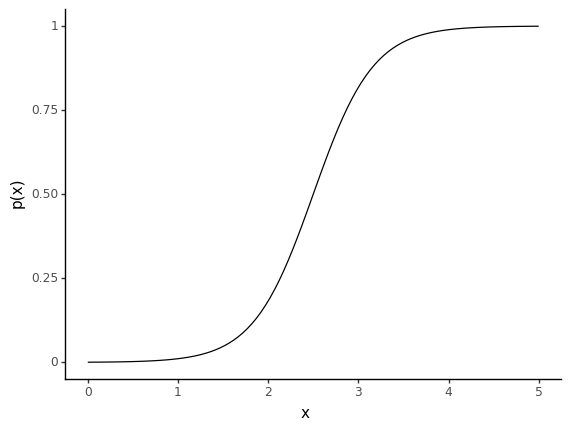

<ggplot: (8730393952988)>

In [2]:
import numpy as np
import pandas as pd
from logistic.plots import plot_smooth_logistic_curve

def logistic(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

def create_smooth_logistic_curve_data(k, x0, n_points=100):
    df = pd.DataFrame({'x': np.linspace(0, 5, n_points)})
    df['p_x'] = logistic(df['x'], k, x0)
    return df

smooth_curve_data = create_smooth_logistic_curve_data(k=3, x0=2.5)
plot_smooth_logistic_curve(smooth_curve_data)

The meaning of these two parameters is:
- $x_0$ is the value of a predictor x for which the probability is 0.5 (mid-point): $p(x = x_0) = 0.5$, so tells us about the location of the mid-point.
- $k$ is related to the slope of the probability at mid-point: $(dp/dx)_{x = x_0} = k/4$, so tells us about the steepness of the curve at that mid-point. The larger the $k$, the steeper the curve in the middle.

In addition to reflecting the slope of this curve, $k$ (originally $\beta_1$) has another meaning under the name _log odds ratio_. Odds ratio describes the change in odds, when $x$ increases by 1:

$$\mathrm{log\ odds\ ratio} = \log \frac{\mathrm{odds}(x+1)}{\mathrm{odds}(x)} = \log \left[\frac{\frac{p(x+1)}{1-p(x+1)}}{\frac{p(x)}{1-p(x)}} \right]= k$$

Therefore, odds ratio is a ratio of ratios of probabilities. As you can tell, odds ratio is not the most intuitive measure, although that is what logistic regression estimates. If increasing x by one unit, increases the probability of y=1 from 0.1 (odds = 0.11) to 0.2 (odds = 0.25), that is represented by odds ratio of 0.25/0.1 = 2.27.

Keep in mind large odds ratio do not need to reflect large absolute probabilities. For example, if increasing x by one unit, increases the probability of y=1 from 0.0001 (odds = 0.0001) to 0.001 (odds = 0.001), this leads to odds ratio of 0.001/0.0001 = 10. So high odds ratio needs to be used with a grain of salt when the probability of y=1 is small. There are alternatives to odds ratio, such as [relative risk](https://www.statology.org/interpret-relative-risk/) which are more interpretable, but may not be simple to calculate or use for statistical inference.

## Naïve least-square fit

As mentioned earlier, the fitting process in logistic regression is different than in linear regression. In linear regression, ordinary least square approach takes _vertical differences between the predicted line and data points_ (residuals), squares them, then adds them up.

What if we tried the same here anyway?

Let us add some points to the previous plot to see if this would work or make sense here:

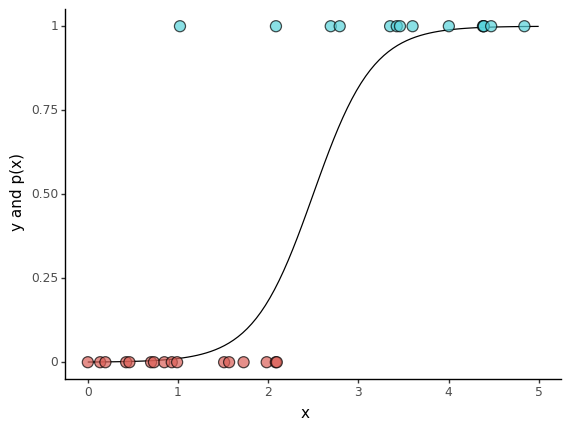

<ggplot: (8730391743738)>

In [3]:
from scipy.stats import uniform, bernoulli
from logistic.plots import plot_naive_logistic_fit

def create_sample_data(k, x0, n_points, seed=1):
    np.random.seed(seed)
    df = pd.DataFrame({
        'x': uniform.rvs(loc=0, scale=5, size=n_points)
    }).sort_values('x', ignore_index=True)
    df['p_x'] = logistic(df['x'], k, x0)
    df['y'] = bernoulli.rvs(df['p_x'])
    return df

plot_naive_logistic_fit(
    create_sample_data(k=3, x0=2.5, n_points=30),
    create_smooth_logistic_curve_data(k=3, x0=2.5)
)

We colored the points at $y = 0$ in <font color="#db5f57">red</font> and points at $y = 1$ in <font color="#57d3db">teal</font>.

First, as opposed to the linear regression, obviously the residuals here do not follow a Normal distribution. Second, residual of each point is always less than 1, which is the upper bound for any residual. Because of this, the left-most top 3 points (for $y = 1$) have almost the same residuals. Bigger outliers will still have larger cost/residuals, but very slightly so. Conceptually, it would make more sense to assign a much larger cost to the first teal point that appears at $x=0$ than to the second one at $x = 1.2$. Either way, this process is not going to work like ordinary least squares does in a linear regression.

## Log-loss fit

Then, what is the approach employed by logistic regression?

* For the <font color="#57d3db">teal</font> points at $y=1$, one way to create a (positive) larger cost at $x=0$ is to take the (negative) logarithm of the fitted probability, $-\log p(x)$.
* For the <font color="#db5f57">red</font> points at $y=0$ we can do the same for the inverted probability, $-\log[1-p(x)]$.

We will call these "log-losses" - for each point $x$ they give us a *cost* of that point being away from the fitted curve. Negative logarithm in $-\log p(x)$ does the trick of making the curve progressively larger, the closer $p(x)$ gets to zero.

In order to utilize `numpy` vectorization, we will code these two together as a single loss function:

$$\mathrm{log\ loss} = -y\log p(x) - (1-y)\log[1 - p(x)]$$

* When $y=0$, the first term is zero and the log-loss is equal to $-\log[1 - p(x)]$.
* When $y=1$, the second term is zero, and the log-loss is $-\log p(x)$.

So writing this way is the same as specifying separate functions for each $y$. This combo expression is also called "cross-entropy" and has an another interpretation in information theory that we will not go into at the moment.

Logistic model fits these two functions simultaneously: $-\log p(x)$ for $y=1$ and $-\log[1 - p(x)]$ for $y=0$. We will collapse all the data points to $y=0$ and plot each of these log-losses separately, to get a better intuition what is happening.

As an example, we will again generate 30 data points, with $k=3$ and $x_0=2.5$ and fit them to the log-losses with same parameters for the illustrative purposes:

In [4]:
def log_loss(p_x, y):
    return -y * np.log(p_x) - (1 - y) * np.log(1 - p_x)

def create_smooth_logloss_data(k, x0, n_points=100):
	x = np.linspace(0, 5, n_points)
	p_x = logistic(x, k, x0)
	return pd.DataFrame({
		'x': np.concatenate((x, x)),
		'y': np.concatenate(([0] * len(x), [1] * len(x))),
		'log_loss': np.concatenate((log_loss(p_x, 0), log_loss(p_x, 1))),
	})

def create_sample_and_logloss_data(k, x0, k_fit, x0_fit, n_points, seed=1):
	df = create_sample_data(k, x0, n_points, seed)
	df['p_x_fit'] = logistic(df['x'], k_fit, x0_fit)
	df['log_loss'] = log_loss(df['p_x_fit'], df['y'])
	logloss_df = create_smooth_logloss_data(k_fit, x0_fit)
	return (df, logloss_df)

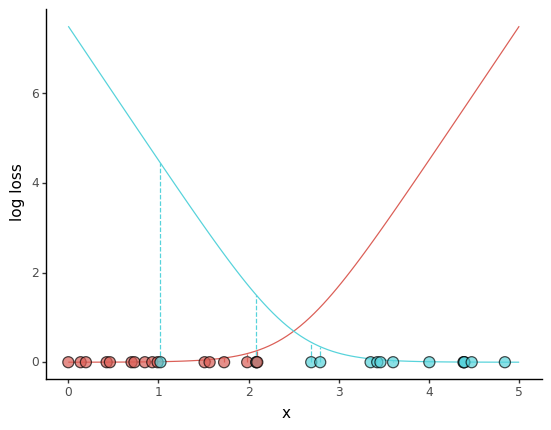

<ggplot: (8730391702269)>

In [5]:
from logistic.plots import plot_logistic_fit

df, logloss_df = create_sample_and_logloss_data(
	k=3,
	x0=2.5,
	k_fit=3,
	x0_fit=2.5,
	n_points=30,
)

plot_logistic_fit(df, logloss_df)

The fitting process is:

* <font color="#db5f57">Red points</font> ($y=0$) are fit to the <font color="db5f57">red "hockey stick" curve</font>: $-\log[1-p(x)]$.
* <font color="#57d3db">Teal points</font> ($y=1$) are fit to the <font color="#57d3db">teal "hockey stick" curve</font>: $-\log p(x)$.
* Both of these curves share the same parameters $k$ and $x_0$, so they change together.
* Sum of the vertical displacements between points is the total cost (or log-loss) that needs to be minimized for various combinations of $k$ and $x_0$

$$\mathrm{total\ log\ loss} = - \sum_{i=1}^{n_{points}}\left[y_i \log p(x_i) + (1 - y_i)\log(1-p(x_i)) \right]$$

As we can see, these curves do have the property of penalizing big outliers proportionally more - they do not have residuals that cap out at one like in our naive fit case.

Unlike ordinary least-square method for linear regression, minimizing this function does not have an analytical solution in the form of an exact mathematical formula. The minimization of log-loss is done using various numerical methods (e.g. gradient descent) or by using a numerical maximum likelihood estimation, which is outside of the scope of this post (but happens to be equivalent to minimizing this exact log-loss).

## Finding the minimal log-loss

How does changing $k$ and $x_0$ affect this fit?

In [6]:
def create_sample_and_logloss_data_from_params(params):
    df_list = []
    logloss_df_list = []
    for x0, k in zip(params['x0'], params['k']):
        df, logloss_df = create_sample_and_logloss_data(
            k=3,
            x0=2.5,
            k_fit=k,
            x0_fit=x0,
            n_points=30
        )
        df['x0_fit'] = logloss_df['x0_fit'] = x0
        df['k_fit'] = logloss_df['k_fit'] = k
        df_list.append(df)
        logloss_df_list.append(logloss_df)

    dfs = pd.concat(df_list, ignore_index=True)
    logloss_dfs = pd.concat(logloss_df_list, ignore_index=True)
    return (dfs, logloss_dfs)

First, we can check that changing $x_0$ again just moves the intersection point left or right:

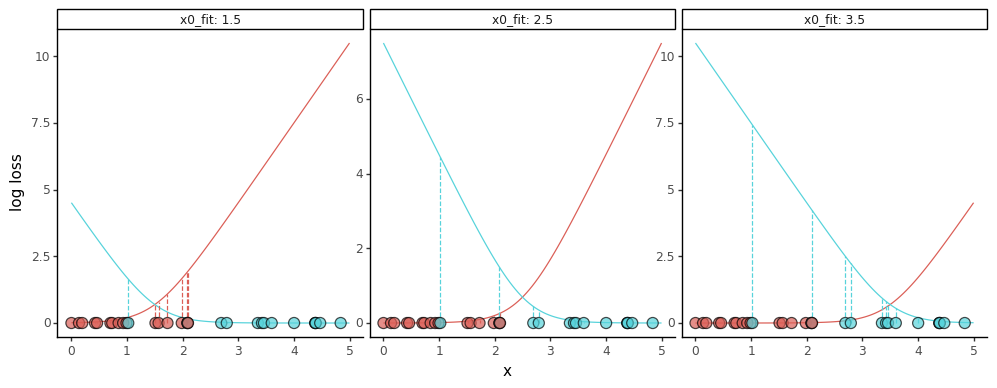

<ggplot: (8730391700839)>

In [7]:
from logistic.plots import plot_logistic_fit_panel

x0_dfs, x0_logloss_dfs = create_sample_and_logloss_data_from_params({
    'x0': [1.5, 2.5, 3.5],
    'k': [3, 3, 3]
})

plot_logistic_fit_panel(x0_dfs, x0_logloss_dfs, '~x0_fit')

So, if $x_0$ is chosen far away from the optimal point, the log-loss increases because increasing number of points gets fitted to the rising parts of the "hockey stick".

Next, notice that changing $k$ changes the sharpness of the "hockey stick" log-loss curves (note the y axis span is different in each plot to show the difference):

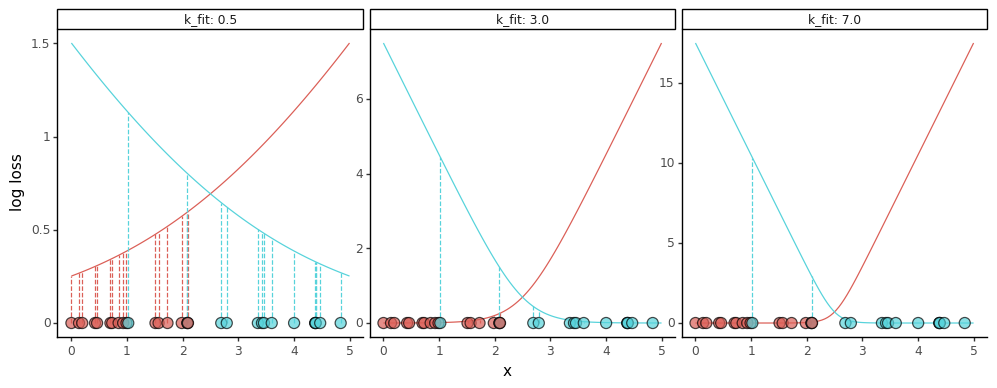

<ggplot: (8730391513188)>

In [8]:
k_dfs, k_logloss_dfs = create_sample_and_logloss_data_from_params({
    'x0': [2.5, 2.5, 2.5],
    'k': [0.5, 3, 7]
})
plot_logistic_fit_panel(k_dfs, k_logloss_dfs, '~k_fit')

* If $k$ is too low (0.5), the log-loss looks almost linear. Most points have add a small but significant amount to the total log-loss. 
* If $k$ is too high (7), most points on the "correct side" of $x = 2.5$ add a negligible amount to the total log-loss but few points on the "wrong side" will add a large amount to the total log-loss.

In fact, the magnitude of the slope of linear parts of "hockey stick" curves is approximately $k$. We can show this for the teal curve ($x \ll x_0$, so $e^{-k(x-x_0)} \gg 1$):

$$-\log p(x) = -\log \frac{1}{1 + e^{-k(x-x_0)}} \approx -\log \frac{1}{e^{-k(x-x_0)}} = -kx + kx_0$$

The total log-loss for each parameter $k = \{0.5, 3, 7\}$ is:

In [9]:
k_dfs.groupby('k_fit')['log_loss'].sum()

k_fit
0.5    13.550052
3.0     7.933129
7.0    13.791910
Name: log_loss, dtype: float64

and similarly for $x_0 = \{1.5, 2.5, 3.5\}$:

In [10]:
x0_dfs.groupby('x0_fit')['log_loss'].sum()

x0_fit
1.5    10.796461
2.5     7.933129
3.5    20.002475
Name: log_loss, dtype: float64

## Running the logistic model

Of course, in practice the algorithms for finding the optimal parameters are built into R/Python. We will use Python's `statsmodels` library. Just keep in mind: functions in these libraries parametrize the probability using $\beta$ s instead of $k$ and $x_0$ we used:

$$p(x) = \frac{1}{1 + e^{-k(x - x_0)}} = \frac{1}{1 + e^{-(\beta_1 x + \beta_0)}}$$

where the relationship between $k, x_0$ and $\beta_1, \beta_0$ is:

$$\beta_1 = k,\quad \beta_0 = - kx_0$$

so our model with $k=3$ and $x_0=2.5$ translates to $\beta_1=3$ and $\beta_0=-7.5$:

In [11]:
import statsmodels.formula.api as smf
model = smf.logit('y ~ x', df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.230366
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 May 2023   Pseudo R-squ.:                  0.6666
Time:                        20:53:08   Log-Likelihood:                -6.9110
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                 1.466e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.6829      2.196     -2.588      0.010      -9.986      -1.380
x              2.6187      1.025      2.554      0.011       0.609       4.628
==============================================================================
"""

Since we have very few data points and because the seed was chosen to showcase an example with outliers, the fit is not perfect, but we can read out the model parameters:

$$\beta_1 = 2.6187, \quad \beta_0 = -5.6829$$

and the total log-loss is here reported as "Log-Likelihood", which is just negative total log-loss and equals -6.911.

## Limitations of logistic regression

Since the parameters of the logistic model are obtained numerically (commonly using maximum likelihood estimation), this process can fail to converge for a number of reasons, such as:

1. large number of predictors $x_i$ compared to the number of samples
2. predictors that have high or perfect correlations
3. categorical predictors that contain a lot of missing categories
4. perfect separation 😮

Issues 1. and 2. can be corrected using various regularization methods or taking out problematic predictors from the model. Issue 3. can be fixed by re-grouping categories or in some other way filling in missing categories. Issue 4., perfect separation, is another cause for non-convergence, and an Achilles' heel of a logistic regression. It is difficult to resolve it directly - without switching to Bayesian logistic regression, so it warrants further discussion.

### Perfectly separated data

By definition, logistic model cannot fit data that is perfectly separated! We can apply what we learned earlier about model fitting to understand why perfectly separated data cannot be represented using logistic model. Start with creating perfectly separated data and show the exact fit (we again chose $k=3$ and $x_0=2.5$):

In [12]:
def create_perfectly_sep_data_and_logloss(k, x0, n_points_per_group, seed=1):
    np.random.seed(seed)
    perfect_sep_data = pd.DataFrame({
        'x': np.concatenate((
            uniform.rvs(loc=0, scale=2.5, size=n_points_per_group),
            uniform.rvs(loc=2.5, scale=2.5, size=n_points_per_group)
        )),
        'y': np.concatenate((
            [0] * n_points_per_group,
            [1] * n_points_per_group
        ))
    }).sort_values('x', ignore_index=True)
    perfect_sep_data['p_x'] = logistic(perfect_sep_data['x'], k, x0)
    perfect_sep_data['log_loss'] = log_loss(perfect_sep_data['p_x'], perfect_sep_data['y'])

    logloss_df = create_smooth_logloss_data(k, x0)
    return (perfect_sep_data, logloss_df)

Total log-loss:  3.282022354606257


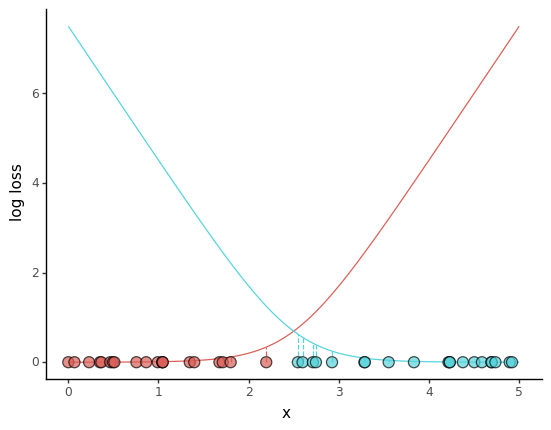

<ggplot: (8730389790449)>

In [13]:
perfect_sep_data, logloss_df = create_perfectly_sep_data_and_logloss(
    k=3,
    x0=2.5,
    n_points_per_group=20,
)

print("Total log-loss: ", perfect_sep_data['log_loss'].sum())

logistic_plot = plot_logistic_fit(perfect_sep_data, logloss_df)
# logistic_plot += p9.ylim(0, 1.5)
logistic_plot

Remember how changing $k$ affects these "hockey stick" log-loss curves?

The higher the $k$, the better log-loss curves fit the points on the "correct" side of the mid-point - red points on the left and teal points on the right. However, unlike in the previous case, now there are no points on the "wrong" side of the mid-point! These fits can just get better and better without limit or any penalty to continuously increasing $k$.

Here is how the fits look when we set $k = 15$:

Total log-loss:  0.6930512657440677


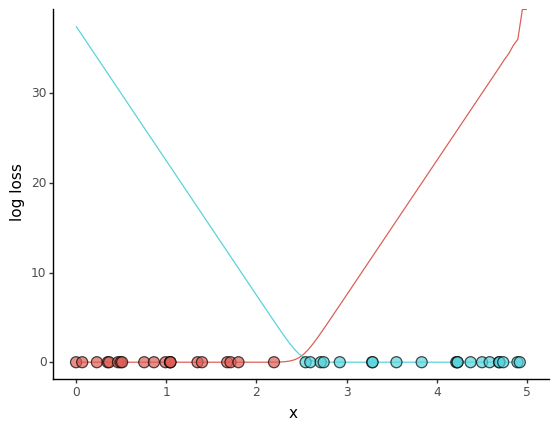

<ggplot: (8730389831280)>

In [14]:
perfect_sep_data, logloss_df = create_perfectly_sep_data_and_logloss(
    k=15,
    x0=2.5,
    n_points_per_group=20,
)
print("Total log-loss: ", perfect_sep_data['log_loss'].sum())

logistic_plot = plot_logistic_fit(perfect_sep_data, logloss_df)
logistic_plot

In other words, perfectly separated data requires "hockey sticks" to be a curve at a 90-degree angle. And the fitted probability to be a sigmoid curve with infinite slope at the mid-point. 

Since the numerical algorithms stop after a finite number of steps, typically they will signal a warning that the algorithm did not find a set of parameters that minimized log-loss (or maximized log-likelihood). These functions do not have a minimum or maximum in this case.

We can verify this using `statsmodels`:

In [15]:
warnings.filterwarnings('default')

In [16]:
perfect_sep_model = smf.logit('y ~ x', perfect_sep_data).fit()
perfect_sep_model.summary()

         Current function value: 0.000000
         Iterations: 35


/home/igor/.cache/pypoetry/virtualenvs/blog--v8k-B20-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 May 2023   Pseudo R-squ.:                   1.000
Time:                        20:53:09   Log-Likelihood:            -4.3491e-08
converged:                      False   LL-Null:                       -27.726
Covariance Type:            nonrobust   LLR p-value:                 9.578e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -238.7054   6.48e+04     -0.004      0.997   -1.27e+05    1.27e+05
x            100.7257   2.74e+04      0.004      0.997   -5.36e+04    5.38e+04
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

Since the model did not converge, it probably should have returned an error, not an innocent warning. Logistic model function in R, `glm(..., family=binomial)` does the same. To quote [R Inferno](https://www.burns-stat.com/pages/Tutor/R_inferno.pdf), Circle 5, Consistency:

> There is a problem with warnings. No one reads them. People have to read
> error messages because no food pellet falls into the tray after they push the
> button. With a warning the machine merely beeps at them but they still get
> their food pellet. Never mind that it might be poison.

Therefore, be careful when doing inference using effect sizes and p-values. In this case the data is perfectly separable - we have a perfect predictor! While the reported p-value ($P > |z|$) is 0.997. Ignoring or misunderstanding these warnings may get you miss some obvious features in the data.

Alternatively, consider simply using a different model. There is a brave new world outside of logistic regression.

## Comment on sklearn LogisticRegression

`sklearn` is a great Python library. It automates and abstracts much of the calculations and provides a simple and consistent way to run many different models. However, in doing so, it does hide a number of things happening in the background. So learning data science concepts from `sklearn` documentation can lead to some misunderstanding.

One of these is that `sklearn.linear_model.LogisticRegression()` by default, using `.predict()` method, _acts_ like a classification model:

In [17]:
from sklearn.linear_model import LogisticRegression

sklearn_logistic = LogisticRegression(penalty=None).fit(
    df['x'].values.reshape(-1, 1),
    df['y'].values,
)

print("Predicted outcomes: ")
sklearn_logistic.predict(
    df['x'].values.reshape(-1, 1)
)

Predicted outcomes: 


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

Keep in mind that `LogisticRegression()` by default uses L2 regularization, which adds an extra term to the log-loss function. To make it comparable with `statsmodels`, use `LogisticRegression(penalty=None)`. Here, it will not matter since we only have one predictor, but if we have two or more, it will give different parameter estimates. Model parameters are available in the model object:

In [18]:
print("beta_1 or log-odds-ratio: ", sklearn_logistic.coef_[0][0])
print("beta_0 or y intercept: ", sklearn_logistic.intercept_[0])

beta_1 or log-odds-ratio:  2.6187462367743803
beta_0 or y intercept:  -5.682896087072998


Under the hood, what `.predict()` does is predicts the outcome based on the larger of the two probabilities: $p$ or $1-p$. If $p > 1-p$ then it predicts 1, otherwise predicts 0. It does not calculate confidence intervals, does not have p-values and does not do any kind of statistical inference or hypothesis testing.

## Conclusion

In this post we tried to give an intuitive explanation to logistic regression, show how to run regression models in Python's `statsmodels` and `scikit-learn` libraries.

Take home points:

* Logistic regression outputs a probability - therefore it is a regression algorithm.
* Logistic regression can be used for classification.
* Parameters are estimated numerically using the difference between data and two "crossed hockey sticks" log-loss curves that serve as a cost function.
* Use `statsmodels` to run a logistic regression when you are interested in statistical inference (hypothesis testing, p-values, etc.)
* Use `scikit-learn` to run a logistic regression when you just want to try predict the outcome.
* Perfectly separable data cannot be modeled using a logistic model. We still get some large odds-ratio - which depends whenever numerical algorithm stops. So it may be used for prediction but the confidence intervals and p-values will be misleading.

I hope this helps you in your data science journey!